In [1]:
import requests, os, zipfile
import glob
import pickle as pk
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Path to the events archive
dataset_zip = '/tmp/events.zip'

# Path to the extracted events
dataset_dir = '/tmp/events/'

# Path to the dataset file
dataset_pkl = '/tmp/dataset.zip'

In [2]:
#@title Dataset Download

import requests, os, zipfile

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

# Download the dataset
download_file_from_google_drive('1ZPgbhToHLXfLg2IPl0QkxgP6I1TI-KdU', dataset_zip)

# Unzip the dataset
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

In [3]:
# Dataset
X = np.zeros(shape=(0, 10, 10), dtype=float)
y = np.zeros(shape=(0), dtype=int)

# Label encoder for labels
label_encoder = LabelEncoder()

# Paths to event files
pkl_paths = glob.glob(dataset_dir + '*.pkl')

# Load the dataset
for pkl_path in pkl_paths:
  # Unpickle an event file
  pkl_file = open(pkl_path, 'rb')
  event = pk.load(pkl_file)
  pkl_file.close()

  # Turn lists into NumPy arrays
  images = np.stack(event[0], axis=0)
  labels = np.stack(event[1], axis=0)

  # Complement the dataset
  X = np.append(X, images, axis=0)
  y = np.append(y, labels, axis=0)

# Check shapes of the dataset
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (1176475, 10, 10)
y shape: (1176475,)


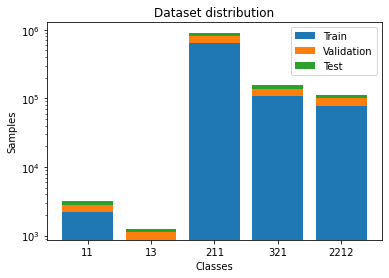

In [4]:
# Get classes and their distribution
classes, counts = np.unique(y, return_counts=True)
class_to_count = dict(zip(classes, counts))

# Splitted dataset distribution
train_counts = counts*.7
val_counts = counts*.2
test_counts = counts*.1

# Plot a stacked bar chart
x = np.arange(len(classes))
bar_train = plt.bar(x, train_counts)
bar_val = plt.bar(x, val_counts, bottom=train_counts)
bar_test = plt.bar(x, test_counts, bottom=(train_counts+val_counts))
plt.yscale('log')
plt.ylabel('Samples')
plt.xlabel('Classes')
plt.title('Dataset distribution')
plt.xticks(x, classes)
plt.legend((bar_train[0], bar_val[0], bar_test[0]), ('Train', 'Validation', 'Test'))
plt.savefig('/tmp/DatasetDistribution.png', bbox_inches='tight')
plt.show()

In [5]:
# Standardize images
X_mean = X.mean(axis=0)
X_sdev = X.std(axis=0)
X_std = (X-X_mean)/X_sdev

# Create a channel dimension
X_std = np.expand_dims(X_std, axis=3)

# Encode labels
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)

# Compute class weights
classes = np.unique(y_enc)
num_classes = len(classes)
class_weight = compute_class_weight('balanced', classes, y_enc)
class_weight = dict(zip(classes, class_weight))

# Check shapes of the dataset
print('X_std shape:', X_std.shape)
print('y_enc shape:', y_enc.shape)

X_std shape: (1176475, 10, 10, 1)
y_enc shape: (1176475,)


In [6]:
# Perform a train/validation/test split
X_train, X_rest, y_train, y_rest = train_test_split(X_std, y_enc, test_size=.3)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=.33)

# Check shapes of the dataset
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

X_train shape: (823532, 10, 10, 1)
X_val shape: (236471, 10, 10, 1)
X_test shape: (116472, 10, 10, 1)
y_train shape: (823532,)
y_val shape: (236471,)
y_test shape: (116472,)


In [7]:
#@title `plot_history()` definition
from matplotlib import pyplot as plt

def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(history.history['loss'], label='training')
  ax1.plot(history.history['val_loss'], label='validation')
  ax1.set_ylabel('Cross-Entropy Loss')
  ax1.set_yscale('log')
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(history.history['lr'], 'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax2.plot(history.history['accuracy'], label='training')
  ax2.plot(history.history['val_accuracy'], label='validation')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.legend()
  plt.show()

In [8]:
def eval_model(model, history, X_test, y_test, classes, encoder, filename):
  # Predict the model on the test data
  y_pred = np.argmax(model.predict(X_test), axis=1)

  # Decode labels
  y_test_decoded = encoder.inverse_transform(y_test)
  y_pred_decoded = encoder.inverse_transform(y_pred)
  classes_decoded = encoder.inverse_transform(classes)

  # Plot the history
  plot_history(history)

  # Build a confusion matrix for the model
  mpl.rcParams.update(mpl.rcParamsDefault)
  cm = confusion_matrix(y_test_decoded, y_pred_decoded, classes_decoded, normalize='true')
  cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_decoded)
  cmd.plot(include_values=True,
          cmap='viridis',
          ax=None,
          xticks_rotation='horizontal')
  plt.savefig(filename, bbox_inches='tight')
  plt.show()

  # Build a table with scores for the model
  print(classification_report(y_test_decoded, y_pred_decoded))

In [9]:
# Define the stop callback
StopCallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1)

# Define hyper parameters
learning_rate = 1e-3
batch_size = 10000
epochs = 100

In [10]:
def build_cnn_model(num_classes, input_shape=(10, 10, 1)):

  # Input layer returning the input_img tensor
  input_img = layers.Input(shape=input_shape)

  # 16 filters with (3, 3) kernel + batch normalization
  x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPool2D((2, 2))(x)

  # 32 filters with (2, 2) kernel + batch normalization
  x = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPool2D((2, 2))(x)

  # Global maximum pooling + dropout
  x = layers.GlobalMaxPool2D()(x)
  x = layers.Dropout(.2)(x)

  # Dense + dropout
  x = layers.Dense(64, activation='relu')(x)
  x = layers.Dropout(.2)(x)

  # Output
  output = layers.Dense(num_classes, 'softmax')(x)

  # Build and compile the model
  model = Model(input_img, output)
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(lr=learning_rate),
                metrics=['accuracy'])

  return model

In [11]:
cnn_model = build_cnn_model(num_classes)
print(cnn_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 10, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 10, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 32)          128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0     

Epoch 1/100
83/83 [==============================] - 9s 28ms/step - loss: 0.9725 - accuracy: 0.7404 - val_loss: 1.1981 - val_accuracy: 0.7684
Epoch 2/100
83/83 [==============================] - 2s 23ms/step - loss: 0.7552 - accuracy: 0.7684 - val_loss: 0.9957 - val_accuracy: 0.7708
Epoch 3/100
83/83 [==============================] - 2s 22ms/step - loss: 0.7342 - accuracy: 0.7700 - val_loss: 0.8604 - val_accuracy: 0.7708
Epoch 4/100
83/83 [==============================] - 2s 22ms/step - loss: 0.7299 - accuracy: 0.7695 - val_loss: 0.7784 - val_accuracy: 0.7708
Epoch 5/100
83/83 [==============================] - 2s 22ms/step - loss: 0.7246 - accuracy: 0.7699 - val_loss: 0.7385 - val_accuracy: 0.7708
Epoch 6/100
83/83 [==============================] - 2s 22ms/step - loss: 0.7248 - accuracy: 0.7694 - val_loss: 0.7223 - val_accuracy: 0.7708
Epoch 7/100
83/83 [==============================] - 2s 22ms/step - loss: 0.7216 - accuracy: 0.7701 - val_loss: 0.7202 - val_accuracy: 0.7708
Epoch 

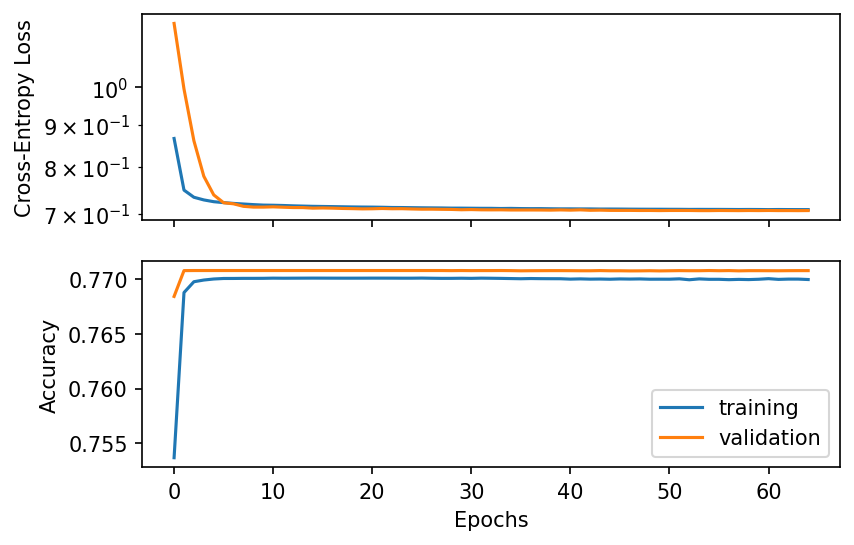

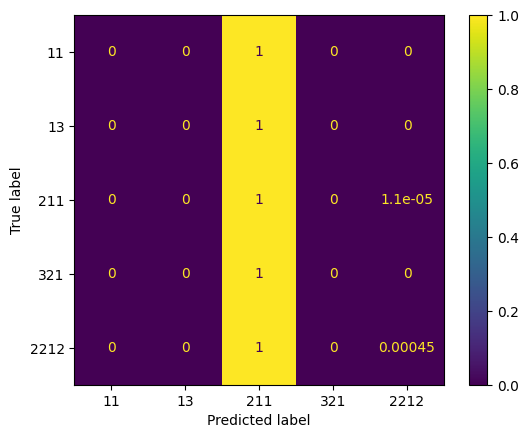

              precision    recall  f1-score   support

          11       0.00      0.00      0.00       316
          13       0.00      0.00      0.00       119
         211       0.77      1.00      0.87     89551
         321       0.00      0.00      0.00     15304
        2212       0.83      0.00      0.00     11182

    accuracy                           0.77    116472
   macro avg       0.32      0.20      0.17    116472
weighted avg       0.67      0.77      0.67    116472



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
# Fit the unbalanced CNN model
cnn_history = cnn_model.fit(X_train,
                            y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(X_val, y_val),
                            callbacks=[StopCallback],
                            verbose=1)

# Evaluate the balanced CNN model
eval_model(cnn_model, cnn_history, X_test, y_test, classes, encoder, '/tmp/CNN_unbalanced_cm.png')

Epoch 1/100
83/83 [==============================] - 2s 24ms/step - loss: 2.1829 - accuracy: 0.1589 - val_loss: 1.6108 - val_accuracy: 0.0715
Epoch 2/100
83/83 [==============================] - 2s 22ms/step - loss: 1.7546 - accuracy: 0.1320 - val_loss: 1.6026 - val_accuracy: 0.1507
Epoch 3/100
83/83 [==============================] - 2s 23ms/step - loss: 1.6523 - accuracy: 0.1741 - val_loss: 1.6049 - val_accuracy: 0.0891
Epoch 4/100
83/83 [==============================] - 2s 22ms/step - loss: 1.6402 - accuracy: 0.1450 - val_loss: 1.6076 - val_accuracy: 0.0370
Epoch 5/100
83/83 [==============================] - 2s 23ms/step - loss: 1.5916 - accuracy: 0.1275 - val_loss: 1.6109 - val_accuracy: 0.0307
Epoch 6/100
83/83 [==============================] - 2s 23ms/step - loss: 1.6179 - accuracy: 0.0940 - val_loss: 1.6126 - val_accuracy: 0.0277
Epoch 7/100
83/83 [==============================] - 2s 22ms/step - loss: 1.5905 - accuracy: 0.0820 - val_loss: 1.6109 - val_accuracy: 0.0300
Epoch 

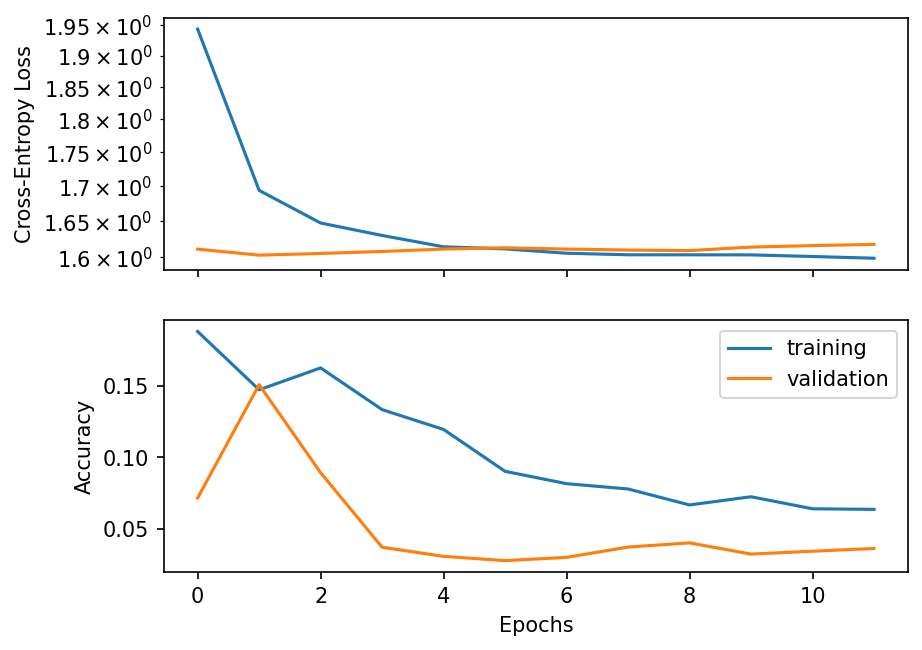

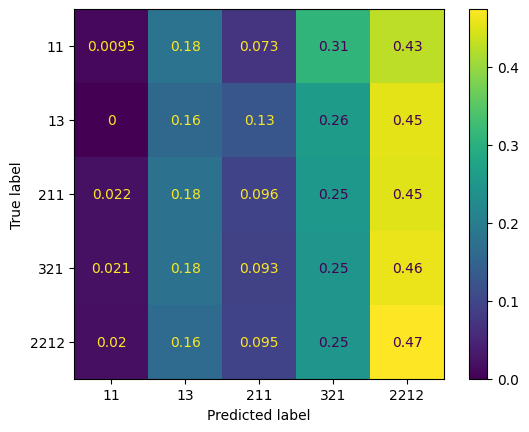

              precision    recall  f1-score   support

          11       0.00      0.01      0.00       316
          13       0.00      0.16      0.00       119
         211       0.77      0.10      0.17     89551
         321       0.13      0.25      0.17     15304
        2212       0.10      0.47      0.17     11182

    accuracy                           0.15    116472
   macro avg       0.20      0.20      0.10    116472
weighted avg       0.62      0.15      0.17    116472



In [19]:
# Fit the balanced CNN model
cnn_model = build_cnn_model(num_classes)
cnn_history = cnn_model.fit(X_train,
                            y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(X_val, y_val),
                            class_weight=class_weight,
                            callbacks=[StopCallback],
                            verbose=1)

# Evaluate the balanced CNN model
eval_model(cnn_model, cnn_history, X_test, y_test, classes, encoder, '/tmp/CNN_balanced_cm.png')

In [14]:
def build_bilstm_model(num_classes, input_shape=(10, 10, 1)):

  # Input layer returning the `input_img` tensor
  input_img = layers.Input(shape=input_shape)

  # Reshape
  x = layers.Reshape(target_shape=(10, 10))(input_img)

  # Bi-directional LSTM
  fw = layers.LSTM(24,
                   dropout=.2)
  bw = layers.LSTM(24,
                   dropout=.2,
                   go_backwards=True)
  x = layers.Bidirectional(fw, backward_layer=bw)(x)

  # BatchNormalization
  x = layers.BatchNormalization()(x)

  # Output
  output = layers.Dense(num_classes, activation='softmax')(x)

  # Build and compile the model
  model = Model(input_img, output)
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(lr=learning_rate),
                metrics=['accuracy'])
  return model

In [15]:
bilstm_model = build_bilstm_model(num_classes)
print(bilstm_model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10, 10, 1)]       0         
_________________________________________________________________
reshape (Reshape)            (None, 10, 10)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 48)                6720      
_________________________________________________________________
batch_normalization_4 (Batch (None, 48)                192       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 245       
Total params: 7,157
Trainable params: 7,061
Non-trainable params: 96
_________________________________________________________________
None


Epoch 1/100
83/83 [==============================] - 3s 16ms/step - loss: 1.0224 - accuracy: 0.7085 - val_loss: 0.7899 - val_accuracy: 0.7708
Epoch 2/100
83/83 [==============================] - 1s 16ms/step - loss: 0.7656 - accuracy: 0.7691 - val_loss: 0.7433 - val_accuracy: 0.7707
Epoch 3/100
83/83 [==============================] - 1s 16ms/step - loss: 0.7370 - accuracy: 0.7694 - val_loss: 0.7277 - val_accuracy: 0.7706
Epoch 4/100
83/83 [==============================] - 1s 15ms/step - loss: 0.7258 - accuracy: 0.7696 - val_loss: 0.7209 - val_accuracy: 0.7706
Epoch 5/100
83/83 [==============================] - 1s 16ms/step - loss: 0.7206 - accuracy: 0.7697 - val_loss: 0.7173 - val_accuracy: 0.7706
Epoch 6/100
83/83 [==============================] - 1s 16ms/step - loss: 0.7179 - accuracy: 0.7698 - val_loss: 0.7151 - val_accuracy: 0.7706
Epoch 7/100
83/83 [==============================] - 1s 16ms/step - loss: 0.7161 - accuracy: 0.7699 - val_loss: 0.7140 - val_accuracy: 0.7706
Epoch 

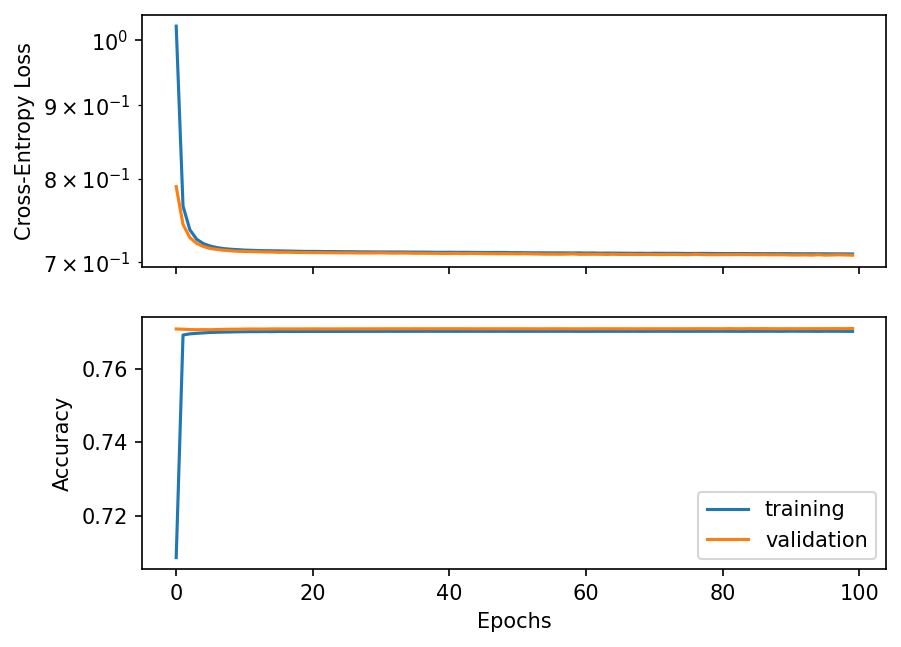

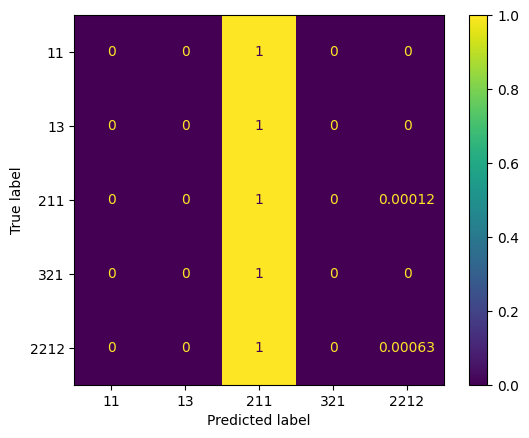

              precision    recall  f1-score   support

          11       0.00      0.00      0.00       316
          13       0.00      0.00      0.00       119
         211       0.77      1.00      0.87     89551
         321       0.00      0.00      0.00     15304
        2212       0.39      0.00      0.00     11182

    accuracy                           0.77    116472
   macro avg       0.23      0.20      0.17    116472
weighted avg       0.63      0.77      0.67    116472



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
# Fit the unbalanced BiLSTM model
bilstm_history = bilstm_model.fit(X_train,
                                  y_train,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  validation_data=(X_val, y_val),
                                  callbacks=[StopCallback],
                                  verbose=1)

# Evaluate the balanced BiLSTM model
eval_model(bilstm_model, bilstm_history, X_test, y_test, classes, encoder, '/tmp/BiLSTM_unbalanced_cm.png')

Epoch 1/100
83/83 [==============================] - 4s 23ms/step - loss: 1.7462 - accuracy: 0.2266 - val_loss: 1.5991 - val_accuracy: 0.2333
Epoch 2/100
83/83 [==============================] - 1s 16ms/step - loss: 1.6363 - accuracy: 0.1422 - val_loss: 1.5700 - val_accuracy: 0.4660
Epoch 3/100
83/83 [==============================] - 1s 16ms/step - loss: 1.6465 - accuracy: 0.1223 - val_loss: 1.5611 - val_accuracy: 0.4352
Epoch 4/100
83/83 [==============================] - 1s 18ms/step - loss: 1.6012 - accuracy: 0.1340 - val_loss: 1.5815 - val_accuracy: 0.2685
Epoch 5/100
83/83 [==============================] - 1s 16ms/step - loss: 1.5850 - accuracy: 0.1248 - val_loss: 1.5935 - val_accuracy: 0.1810
Epoch 6/100
83/83 [==============================] - 1s 16ms/step - loss: 1.5961 - accuracy: 0.1191 - val_loss: 1.6075 - val_accuracy: 0.1017
Epoch 7/100
83/83 [==============================] - 1s 16ms/step - loss: 1.5949 - accuracy: 0.1121 - val_loss: 1.6304 - val_accuracy: 0.0806
Epoch 

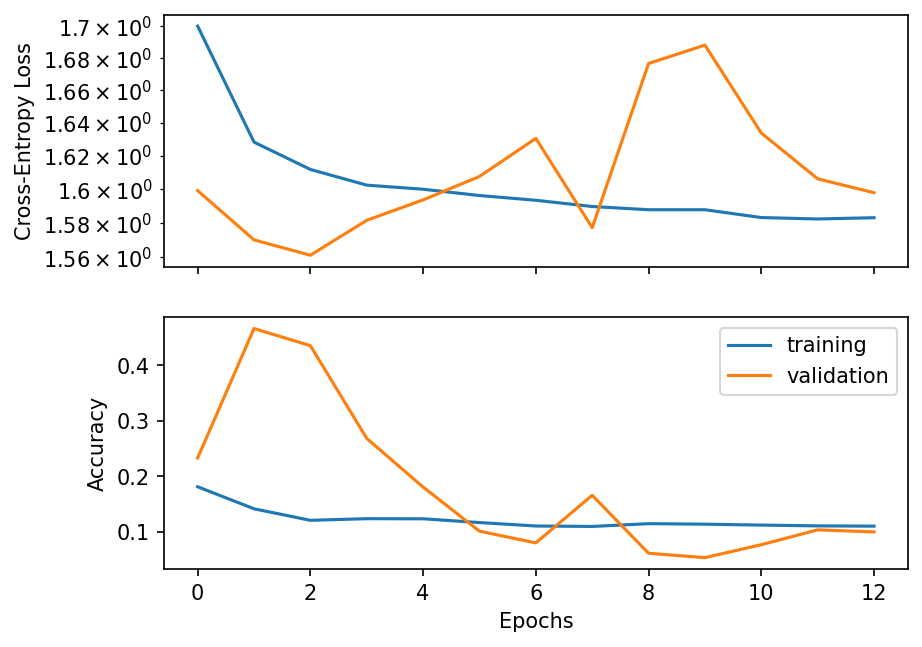

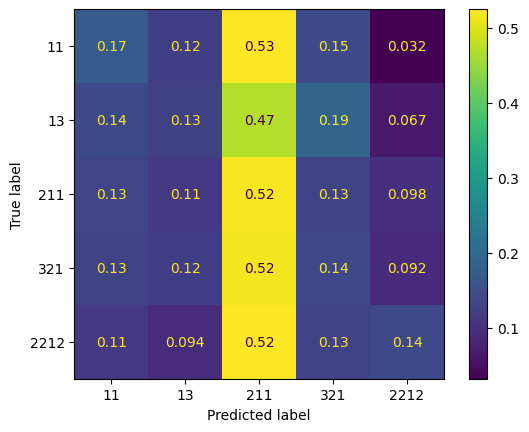

              precision    recall  f1-score   support

          11       0.00      0.17      0.01       316
          13       0.00      0.13      0.00       119
         211       0.77      0.52      0.62     89551
         321       0.14      0.14      0.14     15304
        2212       0.13      0.14      0.14     11182

    accuracy                           0.43    116472
   macro avg       0.21      0.22      0.18    116472
weighted avg       0.62      0.43      0.51    116472



In [17]:
# Fit the balanced BiLSTM model
bilstm_model = build_bilstm_model(num_classes)
bilstm_history = bilstm_model.fit(X_train,
                                  y_train,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  validation_data=(X_val, y_val),
                                  class_weight=class_weight,
                                  callbacks=[StopCallback],
                                  verbose=1)

# Evaluate the balanced BiLSTM model
eval_model(bilstm_model, bilstm_history, X_test, y_test, classes, encoder, '/tmp/BiLSTM_balanced_cm.png')